In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
df = pd.read_csv("Datasets/TilapiaPrice1kg.csv")
df.head()

,Date,Price(USD),Exchange,MYR
0,13/12/2021,3.93,4.2124,16.554732
1,22/11/2021,3.92,4.1858,16.408336
2,1/11/2021,3.75,4.1522,15.570750
3,11/10/2021,3.57,4.1709,14.890113
4,20/09/2021,3.56,4.1919,14.923164


In [3]:
df.describe()

,Price(USD),Exchange,MYR
count,33.000000,33.000000,33.000000
mean,3.963939,4.170809,16.515421
std,0.753720,0.091476,3.074976
min,3.080000,4.042100,12.615680
25%,3.450000,4.111900,14.562498
50%,3.660000,4.153900,14.923164
75%,4.020000,4.224900,16.447600
max,5.410000,4.360600,22.833900


In [4]:
corr = df.corr()

<AxesSubplot:>

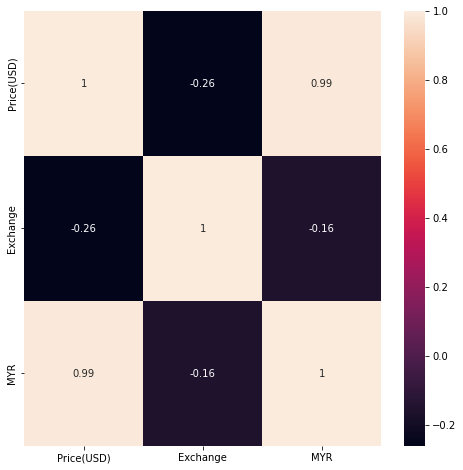

In [5]:
plt.figure(figsize = (8,8))
sns.heatmap(corr, annot=True)

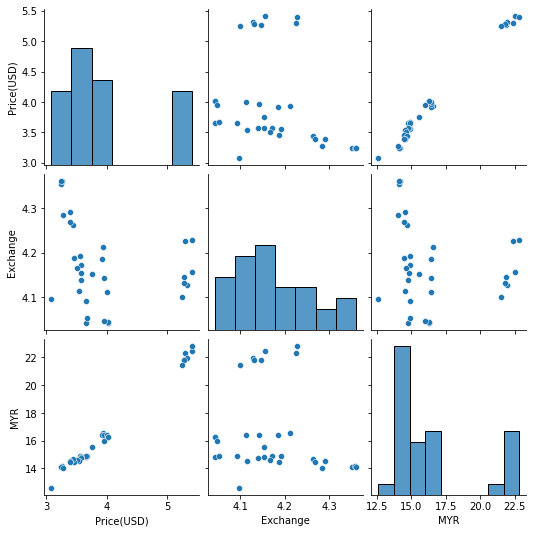

In [6]:
sns.pairplot(df)

c:\Users\hjohn\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='MYR', ylabel='Density'>

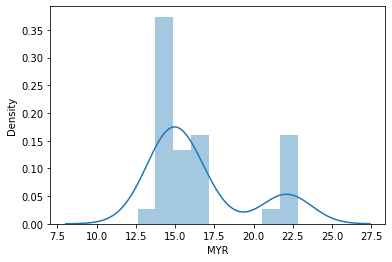

In [7]:
sns.distplot(df['MYR'])

In [8]:
df.shape

(33, 4)

In [9]:
X = df.drop(['Date', 'MYR'], axis='columns')
y = df.MYR

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [12]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [13]:
def best_model(X,y):
    algos = {
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        },
        'RandomForestRegressor': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [10, 50, 100, 130],
                'criterion': ['mse'],
                'max_depth': range(2, 4, 1),
                'max_features': ['auto', 'log2']
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'learning_rate': [0.5, 0.1, 0.01, 0.001],
                'max_depth': [2, 3],
                'n_estimators': [10, 50, 100, 130]
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [14]:
pd.set_option("display.max_colwidth", 100)
best_model(X,y)

c:\Users\hjohn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
c:\Users\hjohn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
c:\Users\hjohn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
c:\Users\hjohn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='square

,model,best_score,best_params
0,decision_tree,0.972350,"{'criterion': 'mse', 'splitter': 'random'}"
1,RandomForestRegressor,0.971498,"{'criterion': 'mse', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 10}"
2,XGBRegressor,0.979602,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 130}"


In [15]:
model = XGBRegressor(learning_rate=0.5, max_depth= 3, n_estimators= 130)

In [16]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=130, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [18]:
model.score(X_test, y_test)

0.7410749583332699

In [19]:
import pickle
pickle.dump(model,open('TilapiaPriceXGBoost.pkl', 'wb'))

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 4 to 3
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price(USD)  24 non-null     float64
 1   Exchange    24 non-null     float64
dtypes: float64(2)
memory usage: 576.0 bytes


In [21]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 31 to 17
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price(USD)  9 non-null      float64
 1   Exchange    9 non-null      float64
dtypes: float64(2)
memory usage: 216.0 bytes


In [22]:
X_test.head()

,Price(USD),Exchange
31,3.28,4.2838
2,3.75,4.1522
25,3.44,4.2629
32,3.08,4.0960
13,4.00,4.1119


In [23]:
pre = model.predict(X_test)
pre

array([14.105753, 14.835014, 14.486811, 14.084013, 16.573488, 14.127621,
       14.865182, 16.248175, 14.422961], dtype=float32)

In [24]:
inp = [4.0,4.132]

In [25]:
model2 = DecisionTreeRegressor(criterion='mse', splitter='best')

In [26]:
model2.fit(X_train, y_train)

c:\Users\hjohn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


DecisionTreeRegressor(criterion='mse')

In [27]:
model2.score(X_test, y_test)

0.7470126632769569

In [28]:
X_test.head()

,Price(USD),Exchange
31,3.28,4.2838
2,3.75,4.1522
25,3.44,4.2629
32,3.08,4.0960
13,4.00,4.1119


In [29]:
model2.predict([[4.0,4.132]])

c:\Users\hjohn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([16.403508])

In [31]:
model2.predict([[20.0,4.132]])

c:\Users\hjohn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([21.957768])

In [32]:
model2.predict(X_test)

array([14.104044, 14.829423, 14.448255, 14.104044, 16.403508, 14.128344,
       14.872308, 16.249242, 14.872308])

In [33]:
import pickle
pickle.dump(model,open('TilapiaPriceDecisionTree.pkl', 'wb'))

In [34]:
import xgboost as xgb
xgb.__version__

'1.6.1'

'0.90'

NameError: name 'xgboost' is not defined